In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing import sequence


C:\Users\Dario\AppData\Local\Temp\ipykernel_5432\4147300727.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ev = pd.read_csv('ia_data_events.csv')


array([[<Axes: title={'center': 'state'}>,
        <Axes: title={'center': 'isMoving'}>],
       [<Axes: title={'center': 'isPumpOn'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

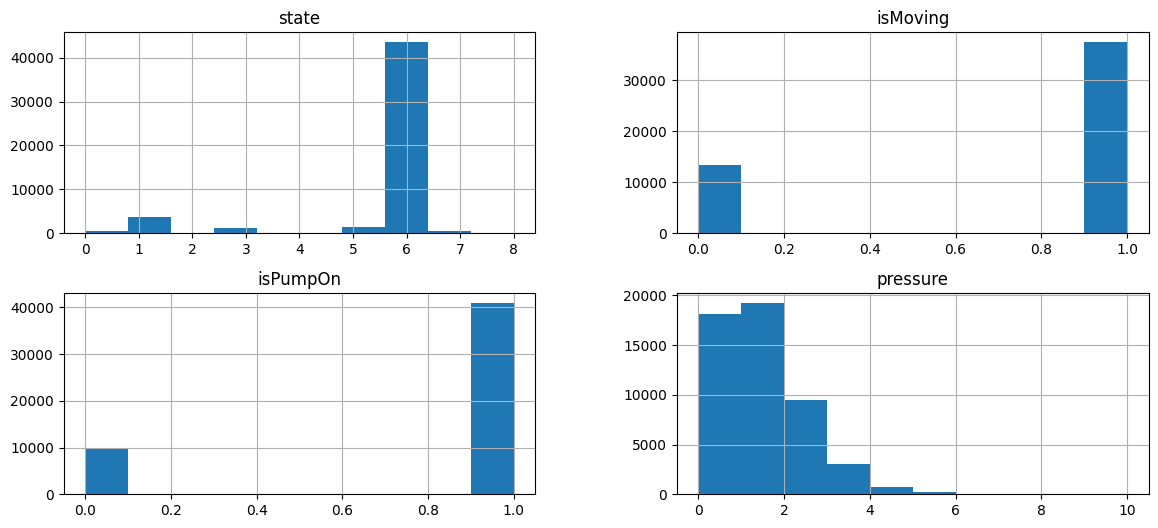

In [37]:
df_ev = pd.read_csv('ia_data_events.csv')
df_ev['isMoving'] = df_ev['isMoving'].astype(int)
df_ev['isPumpOn'] = df_ev['isPumpOn'].astype(int)
df_ev.hist(column=['state', 'isMoving', 'isPumpOn', 'pressure'], figsize=(14, 6))


array([[<Axes: title={'center': 'state'}>,
        <Axes: title={'center': 'isMoving'}>],
       [<Axes: title={'center': 'isPumpOn'}>,
        <Axes: title={'center': 'pressure'}>]], dtype=object)

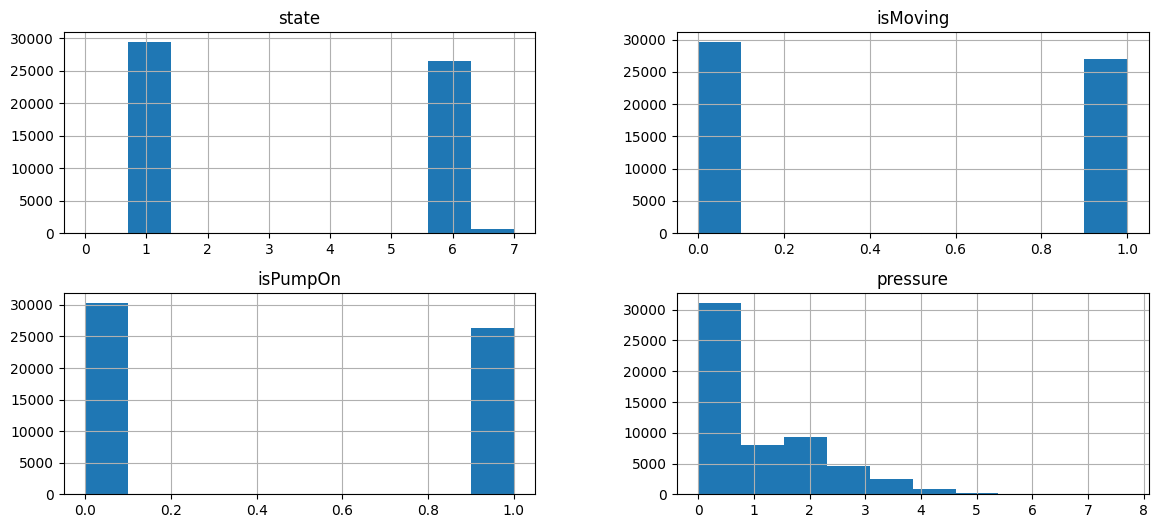

In [38]:
df_nf = pd.read_csv('ia_data_no_fails.csv')
df_nf['isMoving'] = df_nf['isMoving'].astype(int)
df_nf['isPumpOn'] = df_nf['isPumpOn'].astype(int)
df_nf.hist(column=['state', 'isMoving', 'isPumpOn', 'pressure'], figsize=(14, 6))

In [249]:
ALARM_PUMP = 3
ALARM_EQUIPMENT = 5

def prepare_data (df):
  gb = df.groupby('intervalGroup')    
  train = []
  test = []
  for x in gb.groups:
    group = gb.get_group(x)
    group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
    group.loc[group.index[0], 'diffTime'] = 0
    x_group = group.drop(
      ['intervalGroup', 'timeToFail', 'deviceId', 'messageId', 'Time', 'rawSpeed'],
      axis=1
    )
    x_group['direction'] = x_group['direction'].apply(lambda x: 1 if x == 'F' else -1 if x == 'R' else 0)
    train.append(x_group.to_numpy())

    y_group = group[['timeToFail']].copy()
    last_state = x_group['state'].iloc[-1]
    y_group['pe'] = 1 if last_state == ALARM_EQUIPMENT else 0
    y_group['pp'] = 1 if last_state == ALARM_PUMP else 0
    test.append(y_group.to_numpy())
  return train, test


In [251]:
ev_x, ev_y = prepare_data(df_ev)
nf_x, nf_y = prepare_data(df_nf)

C:\Users\Dario\AppData\Local\Temp\ipykernel_5432\2540935257.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
C:\Users\Dario\AppData\Local\Temp\ipykernel_5432\2540935257.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_seconds()
C:\Users\Dario\AppData\Local\Temp\ipykernel_5432\2540935257.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  group.loc[:, 'diffTime'] = pd.to_datetime(group['Time']).diff().dt.total_se

In [229]:
data_x = ev_x + nf_x
data_y = ev_y + nf_y

# timestep_len = max(len(seq) for seq in data_x) # Determine the maximum sequence length
timestep_len = 24
data_x = sequence.pad_sequences(data_x, maxlen=timestep_len, padding='pre', truncating='pre')
data_y = sequence.pad_sequences(data_y, maxlen=timestep_len, padding='pre', truncating='pre')

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.15, random_state=42)
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


x_train (4518, 24, 12)
x_test (798, 24, 12)
y_train (4518, 24, 3)
y_test (798, 24, 3)


In [230]:
def plot_training_history(history):
    # Extract the accuracy and loss from the history object
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [231]:
# def LSTM_Model(features, targets):
#   model = Sequential()
#   model.add(Masking(mask_value=0, input_shape=(24, features)))
#   model.add(LSTM(128, return_sequences=True))
#   model.add(TimeDistributed(Dense(targets)))
#   model.compile(optimizer='adam', loss='mean_squared_error')
#   model.summary()
#   return model

def LSTM_Model(features, targets, timesteps):
  model = Sequential()
  model.add(layers.Masking(mask_value=0, input_shape=(timesteps, features)))
  model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.LSTM(256, return_sequences=False))
  model.add(layers.Dense(128))
  model.add(layers.Dense(timesteps * targets))
  model.add(layers.Reshape((timesteps, targets)))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
  model.summary()
  return model

In [232]:
lstm_model = LSTM_Model(x_train[0].shape[1], y_train[0].shape[1], timestep_len)


C:\Users\Dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\layer.py:934: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_26 (Masking)            │ (None, 24, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 22, 32)         │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 256)            │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 72)             │         9,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 24, 3)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,304 (1.29 MB)

 Trainable params: 339,304 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [234]:
lstm_train = lstm_model.fit(x_train, y_train, shuffle=True, epochs=1000, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5438 - loss: 11294142.0000 - val_accuracy: 0.5764 - val_loss: 11464292.0000
Epoch 2/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5609 - loss: 11391142.0000 - val_accuracy: 0.5716 - val_loss: 11485904.0000
Epoch 3/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5295 - loss: 11173572.0000 - val_accuracy: 0.5513 - val_loss: 11447821.0000
Epoch 4/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5526 - loss: 11301326.0000 - val_accuracy: 0.5724 - val_loss: 11453734.0000
Epoch 5/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5603 - loss: 11310737.0000 - val_accuracy: 0.5511 - val_loss: 11464070.0000
Epoch 6/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5450 - loss: 11206779.0000 - val_accuracy: 0.5766 - val_loss: 11449823.0000
Epoch 7/1000
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5474 - loss: 11349451.0000 - val_accuracy: 0.5481 - val_loss:

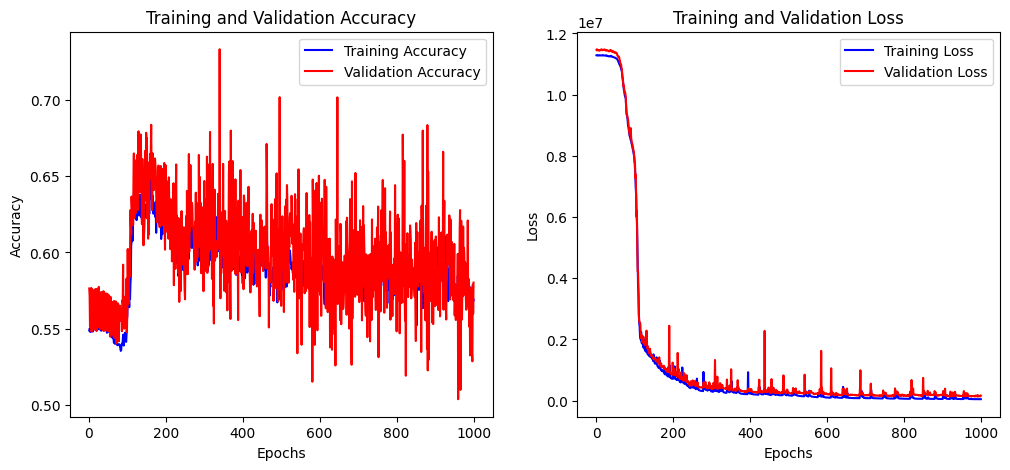

In [235]:
plot_training_history(lstm_train.history)


In [237]:
test = x_test[0].reshape(1, 24, 12)
print(test)
print(y_test[0].reshape(1, 24, 3))
lstm_model(test)

[[[   0    0    0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0    0    0]
  [   0    0    0    0    0    0    0    0    0    0    0    0]
  [ 118    1    0  134    0    0  -38  -58    0    0    0    0]
  [ 120    1    0  134    1    1  -38  -58    1    0    1 1061]
  [ 123    1    1  134    1    1  -38  -58    1    0    6 1013]
  [ 126    1    1  134    1    1  -38  -58    1    0    6  936]
  [ 129    1    1  134    1    1  -38  -58    1    0    6 1047]
  [ 132    1    1  134    1    1  -38  -58    1    0    6 1024]
  [ 134    1    1  134    1    1  -38  -58    1    0    6 1036]
  [ 139    1    1  134    1    1  -38  -58    1    0    6 1247]
  [ 142    1    1  134    1    1  -38  -58    1    0    6 1137]
  [ 145    1    1  134    1    1  -38  -58    1    0    6 1000]
  [ 150    1    1  134    1    1  -38  -58    1    0    6 1309]
  [ 152    1    1  134    1    1  -38  -

<tf.Tensor: shape=(1, 24, 3), dtype=float32, numpy=
array([[[ 1.58648819e+02, -4.89522517e-02,  6.04093909e-01],
        [ 2.40121170e+02, -2.64570475e-01, -3.11124325e-03],
        [ 2.60014153e+01,  6.76331162e-01, -5.56460083e-01],
        [-1.52184849e+01,  5.21822751e-01, -5.26190341e-01],
        [ 2.06915117e+04,  7.23646402e-01,  5.16867340e-01],
        [ 1.94148555e+04,  4.49508101e-01,  3.97768497e-01],
        [ 1.82562207e+04,  2.46446431e-01,  4.27735150e-01],
        [ 1.71469082e+04,  6.06482804e-01,  5.34061670e-01],
        [ 1.61100791e+04,  5.93759298e-01,  7.34027088e-01],
        [ 1.48404727e+04,  4.03032511e-01,  7.50144601e-01],
        [ 1.37363447e+04,  4.78723586e-01,  7.72040963e-01],
        [ 1.26751660e+04,  4.28449303e-01,  6.58037543e-01],
        [ 1.16888574e+04,  3.07885766e-01,  5.28467894e-01],
        [ 1.07192656e+04,  3.60513926e-01,  6.21670485e-01],
        [ 9.71552246e+03,  4.60319728e-01,  5.08669853e-01],
        [ 8.62326172e+03,  1.7215